# COVID-19 SEIRPD-Q model

## Table of Contents

1. [Importing libs](#importing)

2. [Loading data](#loading)

3. [Data cleaning](#cleaning)

4. [(Very) Basic EDA](#eda)

5. [Epidemiology models](#models)

6. [Programming SEIRPD-Q model in Python](#implementations)

7. [Least-squares fitting](#least-squares)

8. [Extrapolation/Predictions](#deterministic-predictions)

9. [Forward UQ](#uq)

10. [Bayesian Calibration](#bayes-calibration)

Before analyze the models, we begin having a look at the available data.

<a id="importing"></a>
## Importing libs

In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
from numba import jit # to accelerate ODE system RHS evaluations
import pymc3 as pm # for uncertainty quantification and model calibration
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3

# Plotting libs
import matplotlib.pyplot as plt
import altair as alt

seed = 12345 # for the sake of reproducibility :)
np.random.seed(seed)

plt.style.use('seaborn-talk') # beautify the plots!

THEANO_FLAGS='optimizer=fast_compile' # A theano trick

<a id="loading"></a>
## Loading data

In [127]:
df_covid = pd.read_csv("../pydemic/data/covid_19_clean_complete.csv", parse_dates=['Date'])

df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17136 entries, 0 to 17135
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  5304 non-null   object        
 1   Country/Region  17136 non-null  object        
 2   Lat             17136 non-null  float64       
 3   Long            17136 non-null  float64       
 4   Date            17136 non-null  datetime64[ns]
 5   Confirmed       17136 non-null  int64         
 6   Deaths          17136 non-null  int64         
 7   Recovered       17136 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.0+ MB


In [128]:
df_covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [129]:
columns_to_filter_cases = ["Country/Region", "Date", "Confirmed", "Deaths"]
df_covid_cases = df_covid[columns_to_filter_cases]

df_covid_cases.head()

,Country/Region,Date,Confirmed,Deaths
0,Afghanistan,2020-01-22,0,0
1,Albania,2020-01-22,0,0
2,Algeria,2020-01-22,0,0
3,Andorra,2020-01-22,0,0
4,Angola,2020-01-22,0,0


<a id="cleaning"></a>
## Data cleaning

Let's do a data cleaning based in this [amazing notebook!](https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper)

In [130]:
print(f"First day entry:\t {df_covid['Date'].min()}")
print(f"Last day reported:\t {df_covid['Date'].max()}")
print(f"Total of tracked days:\t {df_covid['Date'].max() - df_covid['Date'].min()}")

First day entry:	 2020-01-22 00:00:00
Last day reported:	 2020-03-29 00:00:00
Total of tracked days:	 67 days 00:00:00


In [131]:
df_covid.rename(
    columns={
        'Date': 'date', 
        'Province/State':'state',
        'Country/Region':'country',
        'Last Update':'last_updated',
        'Confirmed': 'confirmed',
        'Deaths':'deaths',
        'Recovered':'recovered'}, 
    inplace=True
)

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
17131,NaN,Burma,21.9162,95.9560,2020-03-29,10,0,0
17132,Anguilla,United Kingdom,18.2206,-63.0686,2020-03-29,2,0,0
17133,British Virgin Islands,United Kingdom,18.4207,-64.6400,2020-03-29,2,0,0
17134,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,2020-03-29,4,0,0


Active Case = confirmed - deaths - recovered

In [132]:
df_covid['active'] = df_covid['confirmed'] - df_covid['deaths'] - df_covid['recovered']

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,active
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...,...
17131,NaN,Burma,21.9162,95.9560,2020-03-29,10,0,0,10
17132,Anguilla,United Kingdom,18.2206,-63.0686,2020-03-29,2,0,0,2
17133,British Virgin Islands,United Kingdom,18.4207,-64.6400,2020-03-29,2,0,0,2
17134,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,2020-03-29,4,0,0,4


Replacing Mainland china with just China:

In [133]:
df_covid['country'] = df_covid['country'].replace('Mainland China', 'China')

df_covid

,state,country,Lat,Long,date,confirmed,deaths,recovered,active
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...,...
17131,NaN,Burma,21.9162,95.9560,2020-03-29,10,0,0,10
17132,Anguilla,United Kingdom,18.2206,-63.0686,2020-03-29,2,0,0,2
17133,British Virgin Islands,United Kingdom,18.4207,-64.6400,2020-03-29,2,0,0,2
17134,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,2020-03-29,4,0,0,4


<a id="eda"></a>
## (Very) Basic EDA

Worldwide scenario:

In [134]:
df_grouped = df_covid.groupby('date')['date', 'confirmed', 'deaths'].sum().reset_index()

df_grouped

,date,confirmed,deaths
0,2020-01-22,555,17
1,2020-01-23,654,18
2,2020-01-24,941,26
3,2020-01-25,1434,42
4,2020-01-26,2118,56
...,...,...,...
63,2020-03-25,467653,21181
64,2020-03-26,529591,23970
65,2020-03-27,593291,27198
66,2020-03-28,660706,30652


In [135]:
confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60, color='blue').encode(
    x=alt.X('date', axis=alt.Axis(title='Date')),
    y=alt.Y('confirmed', axis=alt.Axis(title='Cases'))
)

deaths_plot = alt.Chart(df_grouped).mark_circle(size=60, color='red').encode(
    x='date',
    y='deaths'
)

worldwide_plot = confirmed_plot + deaths_plot
worldwide_plot.interactive()

alt.LayerChart(...)

Now, let's take a look at Brazil:

In [136]:
def get_df_country_cases(df: pd.DataFrame, country_name: str) -> pd.DataFrame:
    df_grouped_country = df[df['country'] == country_name].reset_index()
    df_grouped_country_date = df_grouped_country.groupby('date')['date', 'confirmed', 'deaths', 'recovered'].sum().reset_index()
    df_grouped_country_date["confirmed_marker"] = df_grouped_country_date.shape[0] * ['Confirmed']
    df_grouped_country_date["deaths_marker"] = df_grouped_country_date.shape[0] * ['Deaths']
    return df_grouped_country_date


def get_df_state_cases(df: pd.DataFrame, state_name: str) -> pd.DataFrame:
    df_grouped_state = df[df['state'] == state_name].reset_index()
    df_grouped_state_date = df_grouped_state.groupby('date')['date', 'confirmed', 'deaths', 'recovered'].sum().reset_index()
    df_grouped_state_date["confirmed_marker"] = df_grouped_state_date.shape[0] * ['Confirmed']
    df_grouped_state_date["deaths_marker"] = df_grouped_state_date.shape[0] * ['Deaths']
    return df_grouped_state_date

In [137]:
def altair_plot_for_confirmed_and_deaths(df_grouped: pd.DataFrame, data_at_x_axis: str='date') -> alt.Chart:
    confirmed_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=alt.X(data_at_x_axis, axis=alt.Axis(title='Date')),
        y=alt.Y('confirmed', axis=alt.Axis(title='Cases'), title='Confirmed'),
        color=alt.Color("confirmed_marker", title="Cases"),
    )

    deaths_plot = alt.Chart(df_grouped).mark_circle(size=60).encode(
        x=data_at_x_axis,
        y='deaths',
        color=alt.Color("deaths_marker"),
    )

    return confirmed_plot + deaths_plot

In [138]:
df_grouped_brazil = get_df_country_cases(df_covid, "Brazil")

df_grouped_brazil

,date,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-22,0,0,0,Confirmed,Deaths
1,2020-01-23,0,0,0,Confirmed,Deaths
2,2020-01-24,0,0,0,Confirmed,Deaths
3,2020-01-25,0,0,0,Confirmed,Deaths
4,2020-01-26,0,0,0,Confirmed,Deaths
...,...,...,...,...,...,...
63,2020-03-25,2554,59,2,Confirmed,Deaths
64,2020-03-26,2985,77,6,Confirmed,Deaths
65,2020-03-27,3417,92,6,Confirmed,Deaths
66,2020-03-28,3904,111,6,Confirmed,Deaths


In [139]:
altair_plot_for_confirmed_and_deaths(df_grouped_brazil).interactive()

alt.LayerChart(...)

Let's have a look at China:

In [140]:
df_grouped_china = get_df_country_cases(df_covid, "China")

df_grouped_china

,date,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-22,548,17,28,Confirmed,Deaths
1,2020-01-23,643,18,30,Confirmed,Deaths
2,2020-01-24,920,26,36,Confirmed,Deaths
3,2020-01-25,1406,42,39,Confirmed,Deaths
4,2020-01-26,2075,56,49,Confirmed,Deaths
...,...,...,...,...,...,...
63,2020-03-25,81661,3285,73773,Confirmed,Deaths
64,2020-03-26,81782,3291,74181,Confirmed,Deaths
65,2020-03-27,81897,3296,74720,Confirmed,Deaths
66,2020-03-28,81999,3299,75100,Confirmed,Deaths


In [141]:
altair_plot_for_confirmed_and_deaths(df_grouped_china).interactive()

alt.LayerChart(...)

Now, let's take a look only at Hubei, which is disease focus in China:

In [142]:
df_grouped_hubei = get_df_state_cases(df_covid, "Hubei")

df_grouped_hubei[:30]

,date,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-22,444,17,28,Confirmed,Deaths
1,2020-01-23,444,17,28,Confirmed,Deaths
2,2020-01-24,549,24,31,Confirmed,Deaths
3,2020-01-25,761,40,32,Confirmed,Deaths
4,2020-01-26,1058,52,42,Confirmed,Deaths
5,2020-01-27,1423,76,45,Confirmed,Deaths
6,2020-01-28,3554,125,80,Confirmed,Deaths
7,2020-01-29,3554,125,88,Confirmed,Deaths
8,2020-01-30,4903,162,90,Confirmed,Deaths
9,2020-01-31,5806,204,141,Confirmed,Deaths


In [143]:
altair_plot_for_confirmed_and_deaths(df_grouped_hubei).interactive()

alt.LayerChart(...)

Now a look at Italy:

In [144]:
df_grouped_italy = get_df_country_cases(df_covid, "Italy")

df_grouped_italy

,date,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-22,0,0,0,Confirmed,Deaths
1,2020-01-23,0,0,0,Confirmed,Deaths
2,2020-01-24,0,0,0,Confirmed,Deaths
3,2020-01-25,0,0,0,Confirmed,Deaths
4,2020-01-26,0,0,0,Confirmed,Deaths
...,...,...,...,...,...,...
63,2020-03-25,74386,7503,9362,Confirmed,Deaths
64,2020-03-26,80589,8215,10361,Confirmed,Deaths
65,2020-03-27,86498,9134,10950,Confirmed,Deaths
66,2020-03-28,92472,10023,12384,Confirmed,Deaths


In [145]:
altair_plot_for_confirmed_and_deaths(df_grouped_italy).interactive()

alt.LayerChart(...)

### Comparison between Brazil and Italy

In [146]:
df_brazil_cases_by_day = df_grouped_brazil[df_grouped_brazil.confirmed > 0]
df_brazil_cases_by_day = df_brazil_cases_by_day.reset_index(drop=True)
df_brazil_cases_by_day['day'] = df_brazil_cases_by_day.date.apply(lambda x: (x - df_brazil_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'recovered', 'confirmed_marker', 'deaths_marker']
df_brazil_cases_by_day = df_brazil_cases_by_day[reordered_columns]

df_brazil_cases_by_day

,date,day,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-02-26,0,1,0,0,Confirmed,Deaths
1,2020-02-27,1,1,0,0,Confirmed,Deaths
2,2020-02-28,2,1,0,0,Confirmed,Deaths
3,2020-02-29,3,2,0,0,Confirmed,Deaths
4,2020-03-01,4,2,0,0,Confirmed,Deaths
5,2020-03-02,5,2,0,0,Confirmed,Deaths
6,2020-03-03,6,2,0,0,Confirmed,Deaths
7,2020-03-04,7,4,0,0,Confirmed,Deaths
8,2020-03-05,8,4,0,0,Confirmed,Deaths
9,2020-03-06,9,13,0,0,Confirmed,Deaths


In [147]:
df_italy_cases_by_day = df_grouped_italy[df_grouped_italy.confirmed > 0]
df_italy_cases_by_day = df_italy_cases_by_day.reset_index(drop=True)
df_italy_cases_by_day['day'] = df_italy_cases_by_day.date.apply(lambda x: (x - df_italy_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'recovered', 'confirmed_marker', 'deaths_marker']
df_italy_cases_by_day = df_italy_cases_by_day[reordered_columns]

df_italy_cases_by_day

,date,day,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-31,0,2,0,0,Confirmed,Deaths
1,2020-02-01,1,2,0,0,Confirmed,Deaths
2,2020-02-02,2,2,0,0,Confirmed,Deaths
3,2020-02-03,3,2,0,0,Confirmed,Deaths
4,2020-02-04,4,2,0,0,Confirmed,Deaths
5,2020-02-05,5,2,0,0,Confirmed,Deaths
6,2020-02-06,6,2,0,0,Confirmed,Deaths
7,2020-02-07,7,3,0,0,Confirmed,Deaths
8,2020-02-08,8,3,0,0,Confirmed,Deaths
9,2020-02-09,9,3,0,0,Confirmed,Deaths


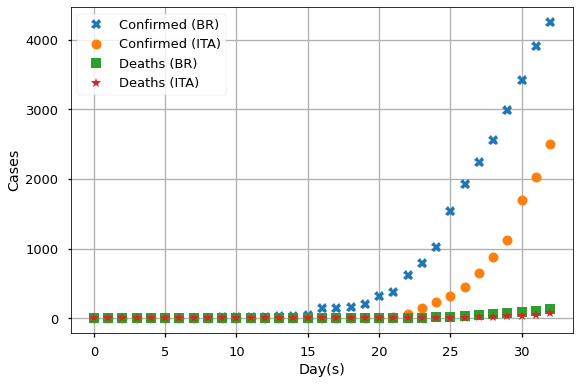

In [148]:
df_italy_cases_by_day_limited_by_br = df_italy_cases_by_day[df_italy_cases_by_day.day <= df_brazil_cases_by_day.day.max()]
days = df_brazil_cases_by_day.day

plt.figure(figsize=(9, 6))
plt.plot(days, df_brazil_cases_by_day.confirmed, marker='X', linestyle="", markersize=10, label='Confirmed (BR)')
plt.plot(days, df_italy_cases_by_day_limited_by_br.confirmed, marker='o', linestyle="", markersize=10, label='Confirmed (ITA)')
plt.plot(days, df_brazil_cases_by_day.deaths, marker='s', linestyle="", markersize=10, label='Deaths (BR)')
plt.plot(days, df_italy_cases_by_day_limited_by_br.deaths, marker='*', linestyle="", markersize=10, label='Deaths (ITA)')

plt.xlabel("Day(s)")
plt.ylabel("Cases")
plt.legend()
plt.grid()

plt.show()

### China scenario since first entry

In [149]:
df_china_cases_by_day = df_grouped_china[df_grouped_china.confirmed > 0]
df_china_cases_by_day = df_china_cases_by_day.reset_index(drop=True)
df_china_cases_by_day['day'] = df_china_cases_by_day.date.apply(lambda x: (x - df_china_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'recovered', 'confirmed_marker', 'deaths_marker']
df_china_cases_by_day = df_china_cases_by_day[reordered_columns]

df_china_cases_by_day

,date,day,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-22,0,548,17,28,Confirmed,Deaths
1,2020-01-23,1,643,18,30,Confirmed,Deaths
2,2020-01-24,2,920,26,36,Confirmed,Deaths
3,2020-01-25,3,1406,42,39,Confirmed,Deaths
4,2020-01-26,4,2075,56,49,Confirmed,Deaths
...,...,...,...,...,...,...,...
63,2020-03-25,63,81661,3285,73773,Confirmed,Deaths
64,2020-03-26,64,81782,3291,74181,Confirmed,Deaths
65,2020-03-27,65,81897,3296,74720,Confirmed,Deaths
66,2020-03-28,66,81999,3299,75100,Confirmed,Deaths


And for Hubei:

In [150]:
df_hubei_cases_by_day = df_grouped_hubei[df_grouped_hubei.confirmed > 0]
df_hubei_cases_by_day = df_hubei_cases_by_day.reset_index(drop=True)
df_hubei_cases_by_day['day'] = df_hubei_cases_by_day.date.apply(lambda x: (x - df_hubei_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'recovered', 'confirmed_marker', 'deaths_marker']
df_hubei_cases_by_day = df_hubei_cases_by_day[reordered_columns]

df_hubei_cases_by_day

,date,day,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-22,0,444,17,28,Confirmed,Deaths
1,2020-01-23,1,444,17,28,Confirmed,Deaths
2,2020-01-24,2,549,24,31,Confirmed,Deaths
3,2020-01-25,3,761,40,32,Confirmed,Deaths
4,2020-01-26,4,1058,52,42,Confirmed,Deaths
...,...,...,...,...,...,...,...
63,2020-03-25,63,67801,3163,60811,Confirmed,Deaths
64,2020-03-26,64,67801,3169,61201,Confirmed,Deaths
65,2020-03-27,65,67801,3174,61732,Confirmed,Deaths
66,2020-03-28,66,67801,3177,62098,Confirmed,Deaths


### Spain since first recorded case

In [151]:
df_grouped_spain = get_df_country_cases(df_covid, "Spain")
df_spain_cases_by_day = df_grouped_spain[df_grouped_spain.confirmed > 0]
df_spain_cases_by_day = df_spain_cases_by_day.reset_index(drop=True)
df_spain_cases_by_day['day'] = df_spain_cases_by_day.date.apply(lambda x: (x - df_spain_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'recovered', 'confirmed_marker', 'deaths_marker']
df_spain_cases_by_day = df_spain_cases_by_day[reordered_columns]

df_spain_cases_by_day

,date,day,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-02-01,0,1,0,0,Confirmed,Deaths
1,2020-02-02,1,1,0,0,Confirmed,Deaths
2,2020-02-03,2,1,0,0,Confirmed,Deaths
3,2020-02-04,3,1,0,0,Confirmed,Deaths
4,2020-02-05,4,1,0,0,Confirmed,Deaths
5,2020-02-06,5,1,0,0,Confirmed,Deaths
6,2020-02-07,6,1,0,0,Confirmed,Deaths
7,2020-02-08,7,1,0,0,Confirmed,Deaths
8,2020-02-09,8,2,0,0,Confirmed,Deaths
9,2020-02-10,9,2,0,0,Confirmed,Deaths


### Iran since first case

In [152]:
df_grouped_iran = get_df_country_cases(df_covid, "Iran")
df_iran_cases_by_day = df_grouped_iran[df_grouped_iran.confirmed > 0]
df_iran_cases_by_day = df_iran_cases_by_day.reset_index(drop=True)
df_iran_cases_by_day['day'] = df_iran_cases_by_day.date.apply(lambda x: (x - df_iran_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'recovered', 'confirmed_marker', 'deaths_marker']
df_iran_cases_by_day = df_iran_cases_by_day[reordered_columns]

df_iran_cases_by_day

,date,day,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-02-19,0,2,2,0,Confirmed,Deaths
1,2020-02-20,1,5,2,0,Confirmed,Deaths
2,2020-02-21,2,18,4,0,Confirmed,Deaths
3,2020-02-22,3,28,5,0,Confirmed,Deaths
4,2020-02-23,4,43,8,0,Confirmed,Deaths
5,2020-02-24,5,61,12,0,Confirmed,Deaths
6,2020-02-25,6,95,16,0,Confirmed,Deaths
7,2020-02-26,7,139,19,49,Confirmed,Deaths
8,2020-02-27,8,245,26,49,Confirmed,Deaths
9,2020-02-28,9,388,34,73,Confirmed,Deaths


### USA since first case

In [153]:
df_grouped_usa = get_df_country_cases(df_covid, "US")
df_usa_cases_by_day = df_grouped_usa[df_grouped_usa.confirmed > 0]
df_usa_cases_by_day = df_usa_cases_by_day.reset_index(drop=True)
df_usa_cases_by_day['day'] = df_usa_cases_by_day.date.apply(lambda x: (x - df_usa_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed', 'deaths', 'recovered', 'confirmed_marker', 'deaths_marker']
df_usa_cases_by_day = df_usa_cases_by_day[reordered_columns]

df_usa_cases_by_day

,date,day,confirmed,deaths,recovered,confirmed_marker,deaths_marker
0,2020-01-22,0,1,0,0,Confirmed,Deaths
1,2020-01-23,1,1,0,0,Confirmed,Deaths
2,2020-01-24,2,2,0,0,Confirmed,Deaths
3,2020-01-25,3,2,0,0,Confirmed,Deaths
4,2020-01-26,4,5,0,0,Confirmed,Deaths
...,...,...,...,...,...,...,...
63,2020-03-25,63,65778,942,361,Confirmed,Deaths
64,2020-03-26,64,83836,1209,681,Confirmed,Deaths
65,2020-03-27,65,101657,1581,869,Confirmed,Deaths
66,2020-03-28,66,121478,2026,1072,Confirmed,Deaths


<a id="models"></a>
## Epidemiology models

Now, let me explore the data in order to calibrate an epidemiologic model in order to try to simulate and predict cases.

### Classical models

Here I present a brief review of classical temporal models (space dependency is not considered). Then I proposed modifications for such models.

#### SIR model

The model represents an epidemic scenario, aiming to predict and control infectious diseases. It consists in a non-linear dynamical system, which considers populational sub-groups according to the state of the individuals. A simple model would be composed by 3 subgroups:

* Susceptible individuals (S);
* Infected (I);
* Recovered (R).

With such components, a classical dynamical system known as SIR model. The equations of such a system is written as:

\begin{align*}
  \dot{S} &= - \beta S I \\ 
  \dot{I} &= \beta S I - \zeta I \\ 
  \dot{R} &= \zeta I
\end{align*}

where $\dot{(\bullet)}$ stands for time-derivative.

Some biological explanation for parameters:

* $\beta$ is the conversion parameter due to interaction between a susceptible individual with an infected one;
* $\zeta$ is the conversion parameter related to the recovery rate. In other words, the individuals that become immune;

#### SEIR model

Another classical model known as SEIR (Susceptible-Exposed-Infected-Recovered) is common applied in Computational Epidemiology literature (you can check it elsewhere). In this model, a new sub-group of individuals is considered: Exposed. Such individuals are those that are infected, but don't show any sympton. In the classical SEIR model, exposed individuals **do not transmit the disease**. The ODE system now becomes:

\begin{align*}
    \dot{S} &= - \beta S  I \\
    \dot{E} &= \beta S I - \alpha E \\
    \dot{I} &= \alpha E - \zeta I \\
    \dot{R} &= \zeta I \\
\end{align*}

Brief biological interpretation for additional parameter:

* $\alpha$ is the conversion parameter for exposed individuals that transformed into infected ones.

### Modified models

Here, I propose some simple modifications in order to improve model representability for COVID-19.

#### Modified SIR model (SIRD)

In this model, deaths due to the disease is considered explicitly. A new individuals sub-group is introduced: dead individuals. To consider such phenomenon, an additional equation is required, as well as a modification in the Infected equation balance. The ODE system is given below:

\begin{align*}
  \dot{S} &= - \beta S I \\ 
  \dot{I} &= \beta S I - \zeta I - \delta I \\ 
  \dot{R} &= \zeta I \\
  \dot{D} &= \delta I
\end{align*}

Brief biological interpretation for additional parameter:

* $\delta$ is the mortality rate for the disease.

#### Modified SEIR model (SEIR-2)

This model aims to solve the lack of the original SEIR model, which does not consider disease transmission between exposed and susceptible individuals. In order to take it into account,
we modified balance equations for S and E as follows:

\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E \\
    \dot{E} &= \beta S I - \alpha E + \gamma S E \\
    \dot{I} &= \alpha E - \zeta I \\
    \dot{R} &= \zeta I \\
\end{align*}

Brief biological interpretation for additional parameter:

* $\gamma$ is the conversion rate parameter for susceptible individuals that interact with exposed individuals and then become exposed.

#### Modified SEIR model with deaths (SEIRD)

Very similiar to the last one, but it considers a sub-population of dead individuals due to the disease. Thus, the model is written as:

\begin{align*}
    \dot{S} &= - \beta S  I  - \gamma S E \\
    \dot{E} &= \beta S I - \alpha E + \gamma S E \\
    \dot{I} &= \alpha E - \zeta I - \delta I \\
    \dot{R} &= \zeta I \\
    \dot{D} &= \delta I
\end{align*}

#### Modified SEIRD model considering quarantine lockdown (SEIRD-Q)

This is a modified model that take into account a removal rate from Susceptible, Exposed and Infected individuals to quarantine. The main hypothesis is that this conversion
is under a constant removal parameter (by time, i.e., 1 / time), and after the conversion, the individual becomes "Recovered" and can not transmit the disease anymore. The new system is written as

\begin{align*}
    \dot{S} &= - \beta S I  - \gamma S E - \omega S\\
    \dot{E} &= \beta S I - \alpha E + \gamma S E - \omega E \\
    \dot{I} &= \alpha E - \zeta I - \delta I - \omega I \\
    \dot{R} &= \zeta I + \omega (S + E + I) \\
    \dot{D} &= \delta I
\end{align*}

Brief biological interpretation for additional parameter:

* $\omega$ is the conversion rate parameter for Susceptible, Exposed and Infected individuals that becomes Recovered due to a removal to a quarantine.

### Remarks for the models units

All sub-population variables (S, I, R, etc) are dimensionless. To obtain the variables, we have to consider that

\begin{align*}
    &S := \frac{\mathcal{S}}{N} \\
    &E := \frac{\mathcal{E}}{N} \\
    &I := \frac{\mathcal{I}}{N} \\
    &R := \frac{\mathcal{R}}{N} \\
    &D := \frac{\mathcal{D}}{N} \\
\end{align*}

with $N$ denoting the total population and $\mathcal{S}$, $\mathcal{E}$, $\mathcal{I}$, $\mathcal{R}$ and $\mathcal{D}$ as the absolute sub-population amounts. Therefore, S, E, I, R and D are given as fractions of the total population.

<a id="implementations"></a>
## Programming SEIRPD-Q model in Python

In [154]:
@jit(nopython=True)
def seir_jia_model(
    t, 
    X, 
    beta=1e-7, 
    gamma_I=0.1, 
    theta=0.16, 
    p=1/6.2, 
    lamb=1/90, 
    sigma=1/7, 
    rho=0.88,
    epsilon_A=1/10,
    epsilon_I=1/3,
    gamma_A=0.15,
    gamma_D=0.14,
    d_I=0.0105,
    d_D=0.003
):
    """
    This is the RHS representation of Jia et al. model.
    """
    S, E, I, R, D, A, Q, F = X
    
    S_prime = - beta * S * (I + theta * A) - p * S + lamb * Q
    E_prime = beta * S * (I + theta * A) - sigma * E
    I_prime = sigma * rho * E - gamma_I * I - d_I * I - epsilon_I * I
    R_prime = gamma_A * A + gamma_I * I + gamma_D * D
    D_prime = epsilon_A * A + epsilon_I * I - d_D * D - gamma_D * D
    A_prime = sigma * (1 - rho) * E - epsilon_A * A - gamma_A * A
    Q_prime = p * S - lamb * Q
    F_prime = d_I * I + d_D * D
    
    return S_prime, E_prime, I_prime, R_prime, D_prime, A_prime, Q_prime, F_prime

ODE solvers wrapper using `scipy.integrate.solve_ivp`:

In [155]:
def seirdaq_ode_solver(
    y0, 
    t_span, 
    t_eval, 
    beta=1e-7, 
    gamma_I=0.1,
    gamma_A=0.15,
    gamma_D=0.14,
    d_I=0.0105,
    d_D=0.003,
    theta=0.16, 
    p=1/6.2, 
    lamb=1/90, 
    sigma=1/7, 
    rho=0.88,
    epsilon_A=1/10,
    epsilon_I=1/3,
):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seir_jia_model(
            t, 
            y, 
            beta=beta, 
            gamma_I=gamma_I, 
            theta=theta, 
            p=p, 
            lamb=lamb, 
            sigma=sigma, 
            rho=rho,
            epsilon_A=epsilon_A,
            epsilon_I=epsilon_I,
            gamma_A=gamma_A,
            gamma_D=gamma_D,
            d_I=d_I,
            d_D=d_D
        ), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

Getting population for each country:

In [177]:
df_population = pd.read_csv("../pydemic/data/countries of the world.csv")

df_population

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,NaN,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",NaN,NaN,NaN,NaN,NaN,"0,02",0,"99,98",1,NaN,NaN,NaN,NaN,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [178]:
brazil_population = float(df_population[df_population.Country == 'Brazil '].Population)
italy_population = float(df_population[df_population.Country == 'Italy '].Population)
china_population = float(df_population[df_population.Country == 'China '].Population)
hubei_population = float(58500000)  # from wikipedia!
spain_population = float(df_population[df_population.Country == 'Spain '].Population)
iran_population = float(df_population[df_population.Country == 'Iran '].Population)
us_population = float(df_population[df_population.Country == 'United States '].Population)

target_population = hubei_population
target_population

58500000.0

Initial Conditions:

In [179]:
df_target_country = df_hubei_cases_by_day[:30]
E0, I0, R0, D0, A0, Q0, F0 = 5 * float(df_target_country.confirmed[0]), 2.5 * float(df_target_country.confirmed[0]), 0., float(df_target_country.confirmed[0]), 0.25 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), float(df_target_country.deaths[0])
#     E0, I0, R0, D0, A0, Q0 = 2280, 1206, 31, 494, 1450, 17751000
S0, E0, I0, R0, D0, A0, Q0, F0 = 41419000, 2280, 1206, 31, 494, 1450, 17751000, df_target_country.deaths[0]
# S0 = target_population - (E0 + I0 + R0 + D0 + A0 + F0)
y0_seirdaq = S0, E0, I0, R0, D0, A0, Q0, F0  # SEIRDAQ IC array
print(y0_seirdaq)

(41419000, 2280, 1206, 31, 494, 1450, 17751000, 17)


<a id="least-squares"></a>
## Least-Squares fitting

Now, we can know how to solve the forward problem, so we can try to fit it with a non-linear Least-Squares method for parameter estimation. Let's begin with a generic Least-Square formulation:

In [159]:
def seirdaq_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, _, _, simulated_qoi1, _, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)


def callback_de(xk, convergence):
    print(f'parameters = {xk}\n')

Setting fitting domain (given time for each observation) and the observations (observed population at given time):

In [160]:
data_time = df_target_country.day.values.astype(np.float64)
infected_individuals = df_target_country.confirmed.values
dead_individuals = df_target_country.deaths.values

To calibrate the model, we define an objective function, which is a Least-Squares function in the present case, and minimize it. To (*try to*) avoid local minima, we use Differential Evolution (DE) method (see this [nice presentation](https://www.maths.uq.edu.au/MASCOS/Multi-Agent04/Fleetwood.pdf) to get yourself introduced to this great subject). In summary, DE is a family of Evolutionary Algorithms that aims to solve Global Optimization problems. Moreover, DE is derivative-free and population-based method.

Below, calibration is performed for selected models:

In [161]:
num_of_parameters_to_fit_seirdaq = 6
#     bounds_seirdaq = num_of_parameters_to_fit_seirdaq * [(0, 1)]
# bounds_seirdaq = [(0, 1e-2), (0, 1), (0, 1), (0, 0.2), (0, 0.2), (0, 0.2)]
bounds_seirdaq = [(0, 1e-2), (1e-3, 0.5)]

result_seirdaq = optimize.differential_evolution(
    seirdaq_least_squares_error_ode, 
    bounds=bounds_seirdaq, 
    args=(data_time, [infected_individuals, dead_individuals], seirdaq_ode_solver, y0_seirdaq), 
    popsize=30,
    strategy='best1bin',
    tol=1e-3,
    recombination=0.7,
#         mutation=0.7,
    maxiter=500,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1
)

print(result_seirdaq)

differential_evolution step 1: f(x)= 5.00358e+14
parameters = [0.00869049 0.49575468]

differential_evolution step 2: f(x)= 4.96045e+14
parameters = [0.00808733 0.49991406]

differential_evolution step 3: f(x)= 4.96045e+14
parameters = [0.00808733 0.49991406]

differential_evolution step 4: f(x)= 4.96045e+14
parameters = [0.00808733 0.49991406]

differential_evolution step 5: f(x)= 4.96045e+14
parameters = [0.00808733 0.49991406]

differential_evolution step 6: f(x)= 4.96045e+14
parameters = [0.00808733 0.49991406]

differential_evolution step 7: f(x)= 4.92016e+14
parameters = [0.00097786 0.49820763]

differential_evolution step 8: f(x)= 4.72762e+14
parameters = [8.12407959e-05 4.90585604e-01]

differential_evolution step 9: f(x)= 4.72762e+14
parameters = [8.12407959e-05 4.90585604e-01]

differential_evolution step 10: f(x)= 4.72762e+14
parameters = [8.12407959e-05 4.90585604e-01]

differential_evolution step 11: f(x)= 4.09633e+14
parameters = [1.40594207e-05 4.93349198e-01]

different

In [162]:
# beta_fitted_seirdaq, gamma_I_fitted_seirdaq = result_seirdaq.x  # SEIRDAQ parameters
# beta_fitted_seirpdq, gamma_fitted_seirpdq, delta_fitted_seirpdq, omega_fitted_seirpdq = result_seirpdq.x  # SEIRDAQ parameters
# beta_fitted_seirpdq, gamma_fitted_seirpdq, delta_fitted_seirpdq = result_seirpdq.x  # SEIRDAQ parameters

In [163]:
t0 = data_time.min()
tf = data_time.max()

solution_ODE_seirdaq = seirdaq_ode_solver(
    y0_seirdaq, 
    (t0, tf), 
    data_time, 
    *result_seirdaq.x
)
t_computed_seirdaq, y_computed_seirdaq = solution_ODE_seirdaq.t, solution_ODE_seirdaq.y
S_seirdaq, E_seirdaq, I_seirdaq, R_seirdaq, D_seirdaq, A_seirdaq, Q_seirdaq, F_seirdaq = y_computed_seirdaq

In [164]:
# model_list = list()
# alpha_list = list()
# beta_list = list()
# delta_list = list()
# gamma_list = list()
# omega_list = list()
# zeta_list = list()

# if has_to_run_sir:
#     model_list.append("SIR")
#     alpha_list.append("-")
#     beta_list.append(np.float(beta_fitted_sir))
#     delta_list.append("-")
#     gamma_list.append("-")
#     omega_list.append("-")
#     zeta_list.append(zeta_fitted)

# if has_to_run_sird:
#     model_list.append("SIRD")
#     alpha_list.append("-")
#     beta_list.append(beta_fitted_sird)
#     delta_list.append(delta_fitted_sird)
#     gamma_list.append("-")
#     omega_list.append("-")
#     zeta_list.append(zeta_fitted)
    
# if has_to_run_seir:
#     model_list.append("SEIR")
#     alpha_list.append(alpha_fitted)
#     beta_list.append(beta_fitted_seir)
#     delta_list.append("-")
#     gamma_list.append(gamma_fitted_seir)
#     omega_list.append("-")
#     zeta_list.append(zeta_fitted)

# if has_to_run_seird:
#     model_list.append("SEIRD")
#     alpha_list.append(alpha_fitted)
#     beta_list.append(beta_fitted_seird)
#     delta_list.append(delta_fitted_seird)
#     gamma_list.append(gamma_fitted_seird)
#     omega_list.append("-")
#     zeta_list.append(zeta_fitted)

# if has_to_run_seirdq:
#     model_list.append("SEIRD-Q")
#     alpha_list.append(alpha_fitted)
#     beta_list.append(beta_fitted_seirdq)
#     delta_list.append(delta_fitted_seirdq)
#     gamma_list.append(gamma_fitted_seirdq)
#     omega_list.append(omega_fitted_seirdq)
#     zeta_list.append(zeta_fitted)
    
# parameters_dict = {
#     "Model": model_list,
#     r"$\alpha$": alpha_list,
#     r"$\beta$": beta_list,
#     r"$\delta$": delta_list,
#     r"$\gamma$": gamma_list,
#     r"$\omega$": omega_list,
#     r"$\zeta$": zeta_list,
# }

# df_parameters_calibrated = pd.DataFrame(parameters_dict)

# df_parameters_calibrated

In [165]:
# print(df_parameters_calibrated.to_latex(index=False))

Show calibration result based on available data:

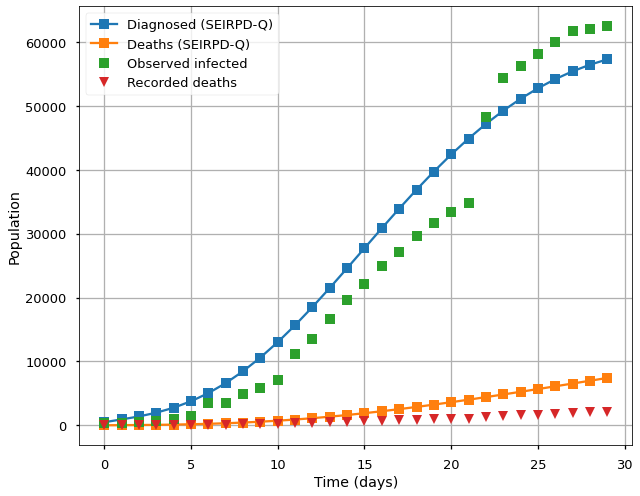

In [166]:
plt.figure(figsize=(9,7))

# plt.plot(t_computed_seirdaq, I_seirdaq * target_population, label='Infected (SEIRDAQ)', marker='X', linestyle="-", markersize=10)
# plt.plot(t_computed_seirdq, R_seirdq * target_population, label='Recovered (SEIRDAQ)', marker='o', linestyle="-", markersize=10)
plt.plot(t_computed_seirdaq, D_seirdaq, label='Diagnosed (SEIRPD-Q)', marker='s', linestyle="-", markersize=10)
plt.plot(t_computed_seirdaq, F_seirdaq, label='Deaths (SEIRPD-Q)', marker='s', linestyle="-", markersize=10)
    
plt.plot(data_time, infected_individuals, label='Observed infected', marker='s', linestyle="", markersize=10)
plt.plot(data_time, dead_individuals, label='Recorded deaths', marker='v', linestyle="", markersize=10)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Population')

plt.tight_layout()
plt.savefig("seirdaq_deterministic_calibration.png")
plt.show()

In [167]:
methods_list = list()
deaths_list = list()

methods_list.append("SEIRQ-Diag")
deaths_list.append(int(F_seirdaq.max()))
print(f"Confirmed cases estimate for today (SEIRQ-Diag):\t {int(D_seirdaq[-1])}")
print(f"Confirmed cases estimate population percentage for today (SEIRQ-Diag):\t{100 * D_seirdaq[-1] / target_population:.3f}%")
print(f"Death estimate for today (SEIRQ-Diag):\t{int(F_seirdaq[-1])}")
print(f"Death estimate population percentage for today (SEIRQ-Diag):\t{100 * F_seirdaq[-1] / target_population:.3f}%")

methods_list.append("Recorded")
deaths_list.append(int(dead_individuals[-1]))

death_estimates_dict = {"Method": methods_list, "Deaths estimate": deaths_list}
df_deaths_estimates = pd.DataFrame(death_estimates_dict)
print(f"Recorded deaths until today:\t{int(dead_individuals[-1])}")

Confirmed cases estimate for today (SEIRQ-Diag):	 57276


NameError: name 'target_population' is not defined

In [168]:
# df_deaths_estimates.set_index("Model", inplace=True)
print(df_deaths_estimates.to_latex(index=False))

NameError: name 'df_deaths_estimates' is not defined

<a id="deterministic-predictions"></a>
## Extrapolation/Predictions

Now, let's extrapolate to next days.

In [169]:
t0 = float(data_time.min())
number_of_days_after_last_record = 90
tf = data_time.max() + number_of_days_after_last_record
time_range = np.linspace(0., tf, int(tf))

solution_ODE_predict_seirdaq = seirdaq_ode_solver(
    y0_seirdaq, 
    (t0, tf), 
    time_range, 
    *result_seirdaq.x
)  # SEIRDAQ
#     solution_ODE_predict_seirdaq = seirdaq_ode_solver(y0_seirdaq, (t0, tf), time_range)  # SEIRDAQ
t_computed_predict_seirdaq, y_computed_predict_seirdaq = solution_ODE_predict_seirdaq.t, solution_ODE_predict_seirdaq.y
S_predict_seirdaq, E_predict_seirdaq, I_predict_seirdaq, R_predict_seirdaq, D_predict_seirdaq, A_predict_seirdaq, Q_predict_seirdaq, F_predict_seirdaq = y_computed_predict_seirdaq

Calculating the day when the number of infected individuals is max:

In [170]:
has_to_plot_infection_peak = True

crisis_day_seirdaq = np.argmax(D_predict_seirdaq) + 1

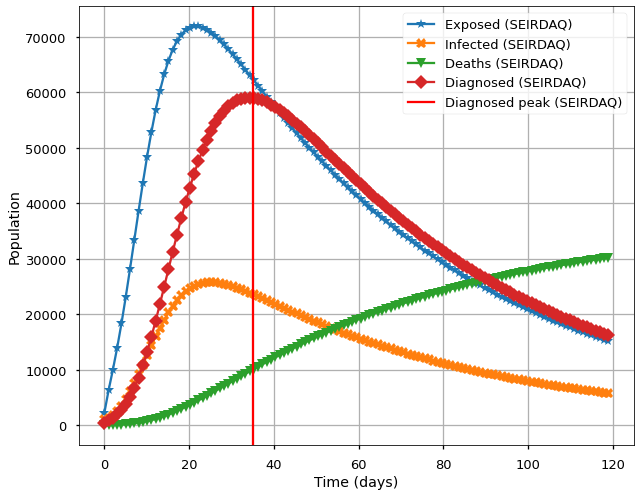

In [171]:
plt.figure(figsize=(9,7))

#     plt.plot(t_computed_predict_seirdaq, S_predict_seirdaq, label='Susceptible (SEIRDAQ)', marker='s', linestyle="-", markersize=10)
plt.plot(t_computed_predict_seirdaq, E_predict_seirdaq, label='Exposed (SEIRDAQ)', marker='*', linestyle="-", markersize=10)
plt.plot(t_computed_predict_seirdaq, I_predict_seirdaq, label='Infected (SEIRDAQ)', marker='X', linestyle="-", markersize=10)
#     plt.plot(t_computed_predict_seirdaq, R_predict_seirdaq, label='Recovered (SEIRDAQ)', marker='o', linestyle="-", markersize=10)
plt.plot(t_computed_predict_seirdaq, F_predict_seirdaq, label='Deaths (SEIRDAQ)', marker='v', linestyle="-", markersize=10)
plt.plot(t_computed_predict_seirdaq, D_predict_seirdaq, label='Diagnosed (SEIRDAQ)', marker='D', linestyle="-", markersize=10)
# plt.plot(t_computed_predict_seirdaq, Q_predict_seirdaq, label='Quarantine (SEIRDAQ)', marker='H', linestyle="-", markersize=10)
if has_to_plot_infection_peak:
    plt.axvline(x=crisis_day_seirdaq, color="red", linestyle="-", label="Diagnosed peak (SEIRDAQ)")

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("seirdaq_deterministic_predictions.png")
plt.show()

In [172]:
print(f"Max number of diagnosed individuals (SEIRDAQ model):\t {int(np.max(D_predict_seirdaq))}")
print(f"Population percentage of max number of diagnosed individuals (SEIRDAQ model):\t {100 * np.max(D_predict_seirdaq) / target_population:.2f}%")
print(f"Day estimate for max number of diagnosed individuals (SEIRDAQ model):\t {crisis_day_seirdaq}")
print(f"Percentage of number of death estimate (SEIRDAQ model):\t {100 * F_predict_seirdaq[-1] / target_population:.3f}%")
print(f"Number of death estimate (SEIRDAQ model):\t {F_predict_seirdaq[-1]:.3f}")

Max number of diagnosed individuals (SEIRDAQ model):	 59053


NameError: name 'target_population' is not defined

<a id="uq"></a>
## Forward Uncertainty Propagation

In [173]:
# @theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dmatrix])
# def seirdaq_ode_wrapper(time_exp, initial_conditions, beta, gamma_I, gamma_A, gamma_D, d_I, d_D):
#     time_span = (time_exp.min(), time_exp.max())
    
#     args = [beta, gamma, delta, theta]
#     y_model = seirpdq_ode_solver(initial_conditions, time_span, time_exp, *args)
#     simulated_time = y_model.t
#     simulated_ode_solution = y_model.y
    
#     return simulated_ode_solution

@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dscalar, t.dscalar], otypes=[t.dmatrix])
def seirdaq_ode_wrapper(time_exp, initial_conditions, beta, gamma_I):
    time_span = (time_exp.min(), time_exp.max())
    
    args = [beta, gamma_I]
    y_model = seirdaq_ode_solver(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    
    return simulated_ode_solution

In [174]:
# beta_deterministic, gamma_I_deterministic, gamma_A_deterministic, gamma_D_deterministic, d_I_deterministic, d_D_deterministic = result_seirdaq.x
beta_deterministic, gamma_I_deterministic = result_seirdaq.x

In [175]:
percent_uq = 10 / 100
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    beta = pm.Uniform('beta', lower=(1 - percent_uq) * beta_deterministic, upper=(1 + percent_uq) * beta_deterministic)
    gamma_I = pm.Uniform('gamma_I', lower=(1 - percent_uq) * gamma_I_deterministic, upper=(1 + percent_uq) * gamma_I_deterministic)
#     gamma_A = pm.Uniform('gamma_A', lower=(1 - percent_uq) * gamma_A_deterministic, upper=(1 + percent_uq) * gamma_A_deterministic)
#     gamma_D = pm.Uniform('gamma_D', lower=(1 - percent_uq) * gamma_D_deterministic, upper=(1 + percent_uq) * gamma_D_deterministic)
#     d_I = pm.Uniform('d_I', lower=(1 - percent_uq) * d_I_deterministic, upper=(1 + percent_uq) * d_I_deterministic)
#     d_D = pm.Uniform('d_D', lower=(1 - percent_uq) * d_D_deterministic, upper=(1 + percent_uq) * d_D_deterministic)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic('seirdaq_model', seirdaq_ode_wrapper(
        theano.shared(time_range), 
        theano.shared(np.float64(np.array(y0_seirdaq))),
        beta,
        gamma_I,
#         gamma_A,
#         gamma_D,
#         d_I,
#         d_D
        )
    )

    # The Monte Carlo procedure driver
    step = pm.step_methods.Metropolis()
    seirdaq_trace = pm.sample(4000, chains=4, cores=4, step=step, random_seed=seed)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [gamma_I]
>Metropolis: [beta]
Sampling 4 chains, 0 divergences:  11%|█         | 1987/18000 [00:26<03:30, 76.11draws/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [113]:
percentile_cut = 5

y_min = np.percentile(seirdaq_trace['seirdaq_model'], percentile_cut, axis=0)
y_max = np.percentile(seirdaq_trace['seirdaq_model'], 100 - percentile_cut, axis=0)
y_fit = np.percentile(seirdaq_trace['seirdaq_model'], 50, axis=0)

NameError: name 'seirdaq_trace' is not defined

In [114]:
plt.figure(figsize=(9, 7))

# plt.plot(time_range, 100 * y_fit[0], 'b', label='Suscetible')
# plt.fill_between(time_range, y_min[0], y_max[0], color='b', alpha=0.2)

# plt.plot(time_range, 100 * y_fit[1], 'r', label='Exposed')
# plt.fill_between(time_range, y_min[1], y_max[1], color='r', alpha=0.2)

# plt.plot(time_range, y_fit[2], 'g', label='Infected')
# plt.fill_between(time_range, y_min[2], y_max[2], color='g', alpha=0.2)

# plt.plot(data_time, 100 * y_fit[3], 'y', label='Recovered')
# plt.fill_between(data_time, y_min[3], y_max[3], color='y', alpha=0.2)

plt.plot(time_range, y_fit[4], 'b', label='Diagnosed (SEIRDAQ)', marker='D', linestyle="-", markersize=10)
plt.fill_between(time_range, y_min[4], y_max[4], color='b', alpha=0.2)

plt.plot(time_range, y_fit[-1], 'r', label='Deaths (SEIRDAQ)', marker='v', linestyle="-", markersize=10)
plt.fill_between(time_range, y_min[-1], y_max[-1], color='r', alpha=0.2)

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.grid()

plt.tight_layout()

plt.savefig('seirdaq_uq.png')
plt.show()

NameError: name 'time_range' is not defined

<a id="bayes-calibration"></a>
## Bayesian Calibration

In [115]:
observations_to_fit = np.vstack([infected_individuals, dead_individuals])

NameError: name 'infected_individuals' is not defined

In [116]:
# @theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dmatrix])
# def seirdaq_ode_wrapper(time_exp, initial_conditions, beta, gamma_I, gamma_A, gamma_D, d_I, d_D):
#     time_span = (time_exp.min(), time_exp.max())
    
#     args = [beta, gamma_I, gamma_A, gamma_D, d_I, d_D]
#     y_model = seirdaq_ode_solver(initial_conditions, time_span, time_exp, *args)
#     simulated_time = y_model.t
#     simulated_ode_solution = y_model.y
#     _, _, _, _, simulated_qoi1, _, _, simulated_qoi2 = simulated_ode_solution
    
#     concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2])
    
#     return concatenate_simulated_qoi


@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dscalar, t.dscalar], otypes=[t.dmatrix])
def seirdaq_ode_wrapper(time_exp, initial_conditions, beta, gamma_I):
    time_span = (time_exp.min(), time_exp.max())
    
    args = [beta, gamma_I]
    y_model = seirdaq_ode_solver(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, _, _, simulated_qoi1, _, _, simulated_qoi2 = simulated_ode_solution
    
    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2])
    
    return concatenate_simulated_qoi

In [117]:
population_uncertain_variance = 0.05 * np.max(dead_individuals)
variance = population_uncertain_variance * population_uncertain_variance
standard_deviation = np.sqrt(variance)

standard_deviation

NameError: name 'dead_individuals' is not defined

In [118]:
percent_calibration = 0.2
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    beta = pm.Uniform('beta', lower=(1 - percent_calibration) * beta_deterministic, upper=(1 + percent_calibration) * beta_deterministic)
    gamma_I = pm.Uniform('gamma_I', lower=1e-3, upper=0.2)
#     gamma_I = pm.Uniform('gamma_I', lower=(1 - percent_calibration) * gamma_I_deterministic, upper=(1 + percent_calibration) * gamma_I_deterministic)
#     gamma_A = pm.Uniform('gamma_A', lower=(1 - percent_calibration) * gamma_A_deterministic, upper=(1 + percent_calibration) * gamma_A_deterministic)
#     gamma_D = pm.Uniform('gamma_D', lower=(1 - percent_calibration) * gamma_D_deterministic, upper=(1 + percent_calibration) * gamma_D_deterministic)
#     d_I = pm.Uniform('d_I', lower=(1 - percent_calibration) * d_I_deterministic, upper=(1 + percent_calibration) * d_I_deterministic)
#     d_D = pm.Uniform('d_D', lower=(1 - percent_calibration) * d_D_deterministic, upper=(1 + percent_calibration) * d_D_deterministic)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic('seirdaq_model', seirdaq_ode_wrapper(
        theano.shared(data_time), 
        theano.shared(np.float64(np.array(y0_seirdaq))),
        beta,
        gamma_I,
#         gamma_A,
#         gamma_D,
#         d_I,
#         d_D
        )
    )
    
    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit)

    # The Monte Carlo procedure driver
    step = pm.step_methods.Metropolis()
    seirdaq_trace_calibration = pm.sample(18000, chains=4, cores=4, step=step, random_seed=seed, tune=2000)

NameError: name 'beta_deterministic' is not defined

In [119]:
plot_step = 100

In [120]:
pm.traceplot(seirdaq_trace_calibration[::plot_step], var_names=('beta'))
plt.savefig('seirdaq_beta_traceplot_cal.png')
plt.show()

pm.traceplot(seirdaq_trace_calibration[::plot_step], var_names=('gamma_I'))
plt.savefig('seirdaq_gamma_I_traceplot_cal.png')
plt.show()

# pm.traceplot(seirdaq_trace_calibration[::plot_step], var_names=('gamma_A'))
# plt.savefig('seirdaq_gamma_A_traceplot_cal.png')
# plt.show()

# pm.traceplot(seirdaq_trace_calibration[::plot_step], var_names=('gamma_D'))
# plt.savefig('seirdaq_gamma_D_traceplot_cal.png')
# plt.show()

# pm.traceplot(seirdaq_trace_calibration[::plot_step], var_names=('d_I'))
# plt.savefig('seirdaq_gamma_d_I_traceplot_cal.png')
# plt.show()

# pm.traceplot(seirdaq_trace_calibration[::plot_step], var_names=('d_D'))
# plt.savefig('seirdaq_gamma_d_D_traceplot_cal.png')
# plt.show()

NameError: name 'seirdaq_trace_calibration' is not defined

In [121]:
pm.plot_posterior(seirdaq_trace_calibration[::plot_step], var_names=('beta'), kind='hist', round_to=5)
plt.savefig('seirdaq_beta_posterior_cal.png')
plt.show()

pm.plot_posterior(seirdaq_trace_calibration[::plot_step], var_names=('gamma_I'), kind='hist', round_to=5)
plt.savefig('seirdaq_gamma_I_posterior_cal.png')
plt.show()

# pm.plot_posterior(seirdaq_trace_calibration[::plot_step], var_names=('gamma_A'), kind='hist', round_to=5)
# plt.savefig('seirdaq_gamma_A_posterior_cal.png')
# plt.show()

# pm.plot_posterior(seirdaq_trace_calibration[::plot_step], var_names=('gamma_D'), kind='hist', round_to=5)
# plt.savefig('seirdaq_gamma_D_posterior_cal.png')
# plt.show()

# pm.plot_posterior(seirdaq_trace_calibration[::plot_step], var_names=('d_I'), kind='hist', round_to=5)
# plt.savefig('seirdaq_d_I_posterior_cal.png')
# plt.show()

# pm.plot_posterior(seirdaq_trace_calibration[::plot_step], var_names=('d_D'), kind='hist', round_to=5)
# plt.savefig('seirdaq_d_D_posterior_cal.png')
# plt.show()

NameError: name 'seirdaq_trace_calibration' is not defined

In [122]:
percentile_cut = 5

y_min = np.percentile(seirdaq_trace_calibration['seirdaq_model'], percentile_cut, axis=0)
y_max = np.percentile(seirdaq_trace_calibration['seirdaq_model'], 100 - percentile_cut, axis=0)
y_fit = np.percentile(seirdaq_trace_calibration['seirdaq_model'], 50, axis=0)

NameError: name 'seirdaq_trace_calibration' is not defined

In [123]:
variance_pop = population_uncertain_variance * population_uncertain_variance
sd_pop = np.sqrt(variance_pop)

sd_pop

NameError: name 'population_uncertain_variance' is not defined

In [124]:
plt.figure(figsize=(9, 7))

plt.plot(data_time, y_fit[0], 'b', label='Diagnosed (SEIRDAQ)', marker='D', linestyle="-", markersize=10)
plt.fill_between(data_time, y_min[0], y_max[0], color='b', alpha=0.2)

plt.plot(data_time, y_fit[1], 'r', label='Deaths (SEIRDAQ)', marker='v', linestyle="-", markersize=10)
plt.fill_between(data_time, y_min[1], y_max[1], color='r', alpha=0.2)

plt.errorbar(data_time, infected_individuals, yerr=sd_pop, label='Observed infected', linestyle='None', marker='s', markersize=10)

plt.errorbar(data_time, dead_individuals, yerr=sd_pop, label='Recorded deaths', marker='v', linestyle="None", markersize=10)

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.grid()

plt.tight_layout()

plt.savefig('seirdaq_calibration_bayes.png')
plt.show()

NameError: name 'data_time' is not defined